THIS PROJECT HAS BEEN PREPARED BY YUSUF ANI AND TARIK ÇARLI
---
**BU PROJE YUSUF ANI VE TARIK ÇARLI TARAFINDAN HAZIRLANMIŞTIR**

# Instructions / Bilgiler
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Use a free TPU device / Lütfen Runtime ayarlarından TPU seçtiğinizden emin olun</h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator. / Runtime bölümünden **Change runtime type** seçeneğini tıklayıp TPU seçebilirsiniz.

# Import Libraries / Gerekli kütüphane yüklemeleri

In [1]:
#@title importing necessary libraries / Python kütüphanelerinin yüklenmesi
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [2]:
#@title import Google Drive / Google Drive entegrasyonu
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
#@title Select project location / Lütfen projenin bulunduğu lokasyonu giriniz
%cd drive/My\ Drive/Ara\ Proje/

[Errno 2] No such file or directory: 'drive/My Drive/Ara Proje/'
/content/drive/My Drive/Ara Proje


In [7]:
#@title Helper methods / Kodun çalışması için gerekli metodlar 

class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(40, 40))
  grid_spec = gridspec.GridSpec(2, 2,width_ratios=[6,6], height_ratios=[6, 6])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()
LABEL_NAMES = np.asarray([
  "background",
"aeroplane",
"bicycle",
"bird",
"boat",
"bottle",
"bus",
"car",
"cat",
"chair",
"cow",
"diningtable",
"dog",
"horse",
"motorbike",
"person",
"pottedplant",
"sheep",
"sofa",
"train",
"tvmonitor"
])
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [11]:
#@title Class Names / Sınıfların isimleri
for i in LABEL_NAMES:
  print(i)

background
aeroplane
bicycle
bird
boat
bottle
bus
car
cat
chair
cow
diningtable
dog
horse
motorbike
person
pottedplant
sheep
sofa
train
tvmonitor


## Select a pretrained model / Eğitilmiş modelin yüklenmesi
We have trained the DeepLab model using various backbone networks. Select one from the MODEL_NAME list.

In [9]:
#@title Deeplab Model Load
model_path = 'DEEPLABV3_SEMANTIC_SEGMANTATION_MODEL.tar.gz'  #@param {type: "string"}
#@markdown Model Deeplabv3 modelini kendiniz eğitebilirsiniz veya hazır modeli aşağıdaki linkteki adresten edinebilirsiz: https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md
#@markdown Link:
_TARBALL_NAME = model_path

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

MODEL = DeepLabModel(_TARBALL_NAME)
print('model loaded successfully!')

model loaded successfully!


## Run on sample images

Select one of sample images (leave `IMAGE_URL` empty) or feed any internet image
url for inference.

Note that this colab uses single scale inference for fast computation,
so the results may slightly differ from the visualizations in the
[README](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md) file,
which uses multi-scale and left-right flipped inputs.

Saving sample-11-1.jpg to sample-11-1.jpg
saved file sample-11-1.jpg
sample-11-1.jpg opening
running deeplab on image...


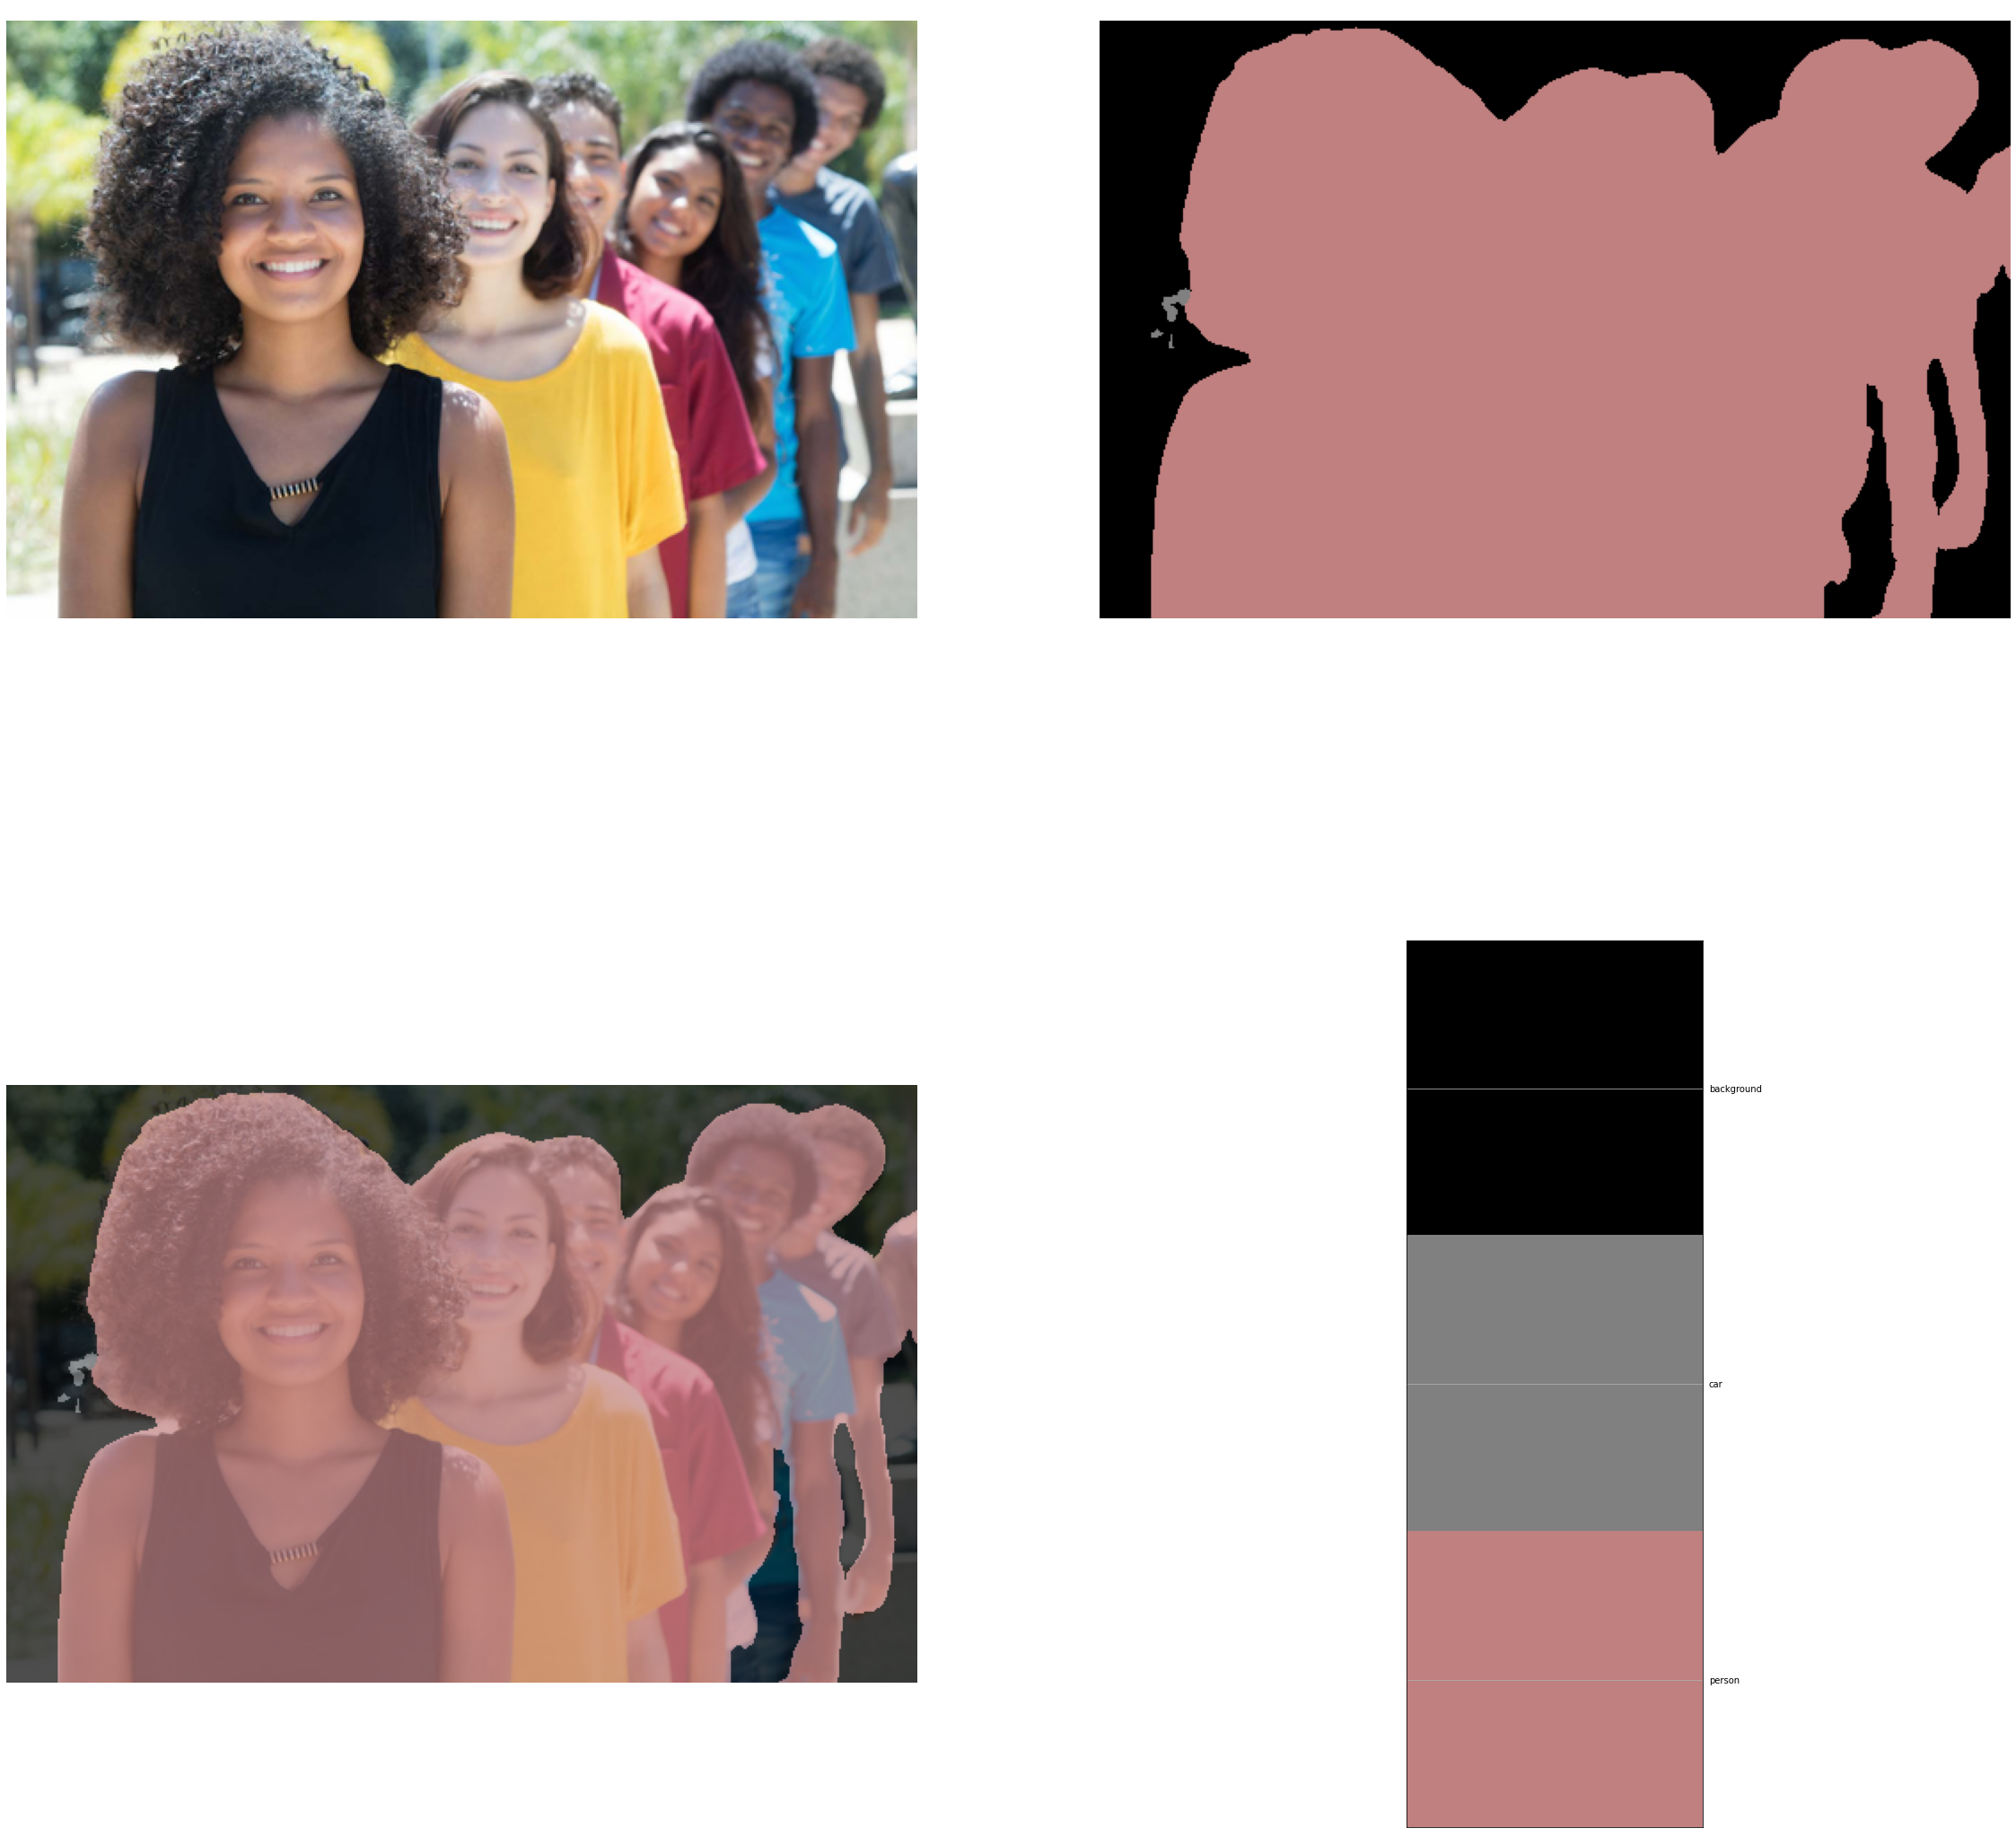

In [40]:
#@title Select the picture to be applied / Uygulanacak resmi seçiniz
import time

from google.colab import files
from os import path
file_name = 'img.jpg'
uploaded = files.upload()
  
for name, data in uploaded.items():
  dic_name = "Result"+name
  if not os.path.exists(dic_name):
    os.mkdir(dic_name)
  with open(dic_name + "/"+name, 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)
print(f"{name} opening")
orignal_im = Image.open(name)

print ('running deeplab on image...' )
start_time= time.time()
resized_im, seg_map = MODEL.run(orignal_im)
segmantation_time= time.time()
vis_segmentation(resized_im, seg_map)

# Before starting, I am converting from PIL image type to numpy array in order to eliminate incompatibility. I also get Tranpose / Başlamadan once uyumsuzluğu gidermek amacıyla PIL image türünden numpy arrayine çeviriyorum . Ayrınca Tranpose alıyorum

import matplotlib.pyplot as plt 
im = np.array(resized_im)
original_im = np.copy(im)


# Connected Component Labeling

In [41]:
#@title  Run Connected Component Labeling / Connected Component Labeling Çalıştır
def make_binary_segment_map(segment,seg_map):
  seg_map[seg_map != segment] = 0 
  seg_map[seg_map == segment] =1
  return seg_map
from scipy.ndimage.measurements import label
def connected_component_labeling(bi_seg_map):
  '''
  This function makes Connected component labeling on binary segment map 
  Returns the largest labeled_seg_map  , label number and area of ​​the largest label
  '''
  structure = np.ones((3, 3), dtype=np.int)
  labeled, ncomponents = label(bi_seg_map, structure)
  print("Compenent sayısı" , ncomponents)
  unique, counts = np.unique(labeled, return_counts=True)
  i, = np.where(unique == 0)  #Delete zero value 
  unique = np.delete(unique,i)  #Delete zero value 
  counts = np.delete(counts,i)  #Delete zero value 
  max_i = counts.argmax() 
  return labeled,unique[max_i],counts[max_i]
  
segments = np.unique(seg_map)
largest_area = -1
largest_bi_seg_map = -1
largest_label_number = -1
for segment in segments:
  if segment != 0 : # Do not take background as object
    bi_seg_map = make_binary_segment_map(segment, np.copy(seg_map))
    labeled_map , lab_num , area = connected_component_labeling(bi_seg_map)
    print(LABEL_NAMES[segment],"->" ,segment,"area ", area)
    if (area > largest_area ):
      print("[[[[Degisti]]]]")
      largest_bi_seg_map , largest_label_number , largest_area =  labeled_map , lab_num , area
connected_component_labeling_time = time.time()
   

Compenent sayısı 3
car -> 7 area  143
[[[[Degisti]]]]
Compenent sayısı 1
person -> 15 area  135367
[[[[Degisti]]]]


We found largest area . 
Lets extract image 

513 513
135367


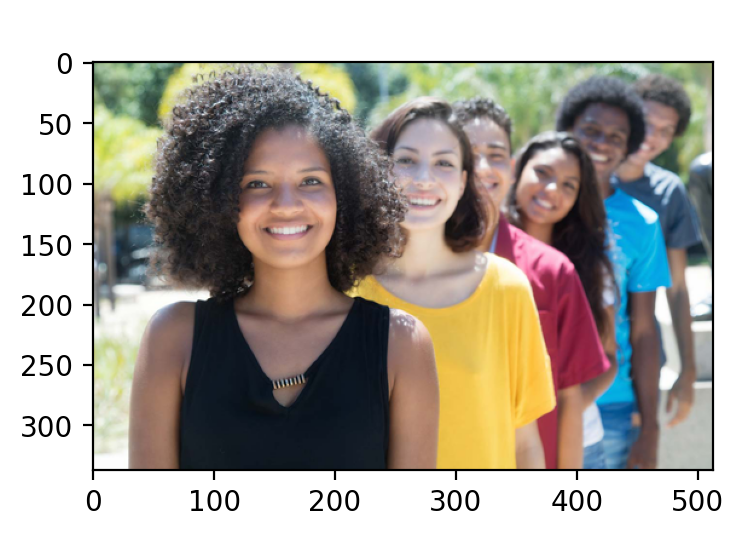

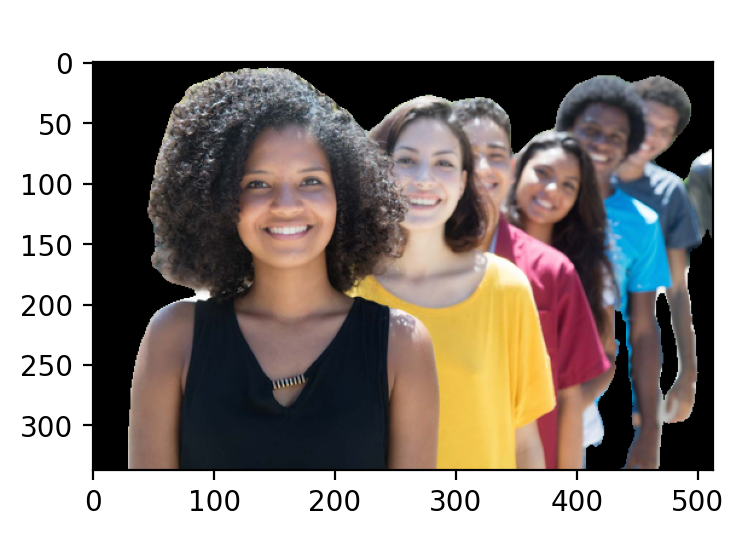

In [42]:
#@title Show Result / Sonucu göster
#background_color =  (140, 115, 115)
background_color =  (0, 0, 0)
mask =np.zeros_like(im,dtype=np.bool)
print(mask.shape[1], mask.shape[1] ) 
hist_array =np.zeros((largest_area,3),dtype=np.uint8)
print(len(hist_array))
#This array for calculate histogram witout zero values 
idx = 0 
w,h,d = im.shape
for i in range(w):
  for j in range(h):
    #print(largest_bi_seg_map[i][j] , largest_label_number )
    if(largest_bi_seg_map[i][j] == largest_label_number):
      hist_array[idx]=im[i][j] 
      idx +=1 
      mask[i][j][:]=(True, True , True)
    else:
      im[i][j] =background_color
plt.figure(1 ,figsize=(4,5) , dpi = 200)
plt.title("Orijinal Resim")
plt.imshow(original_im)

plt.figure(2 ,figsize=(4,5) , dpi = 200)
plt.title("En büyük Component")
plt.imshow(im)



# Color Quantization ( K-means )

Automatically created module for IPython interactive environment
(337, 513, 3)
Fitting model on a small sub-sample of the data
Predicting color indices on the full image (k-means)
Fitting model on a small sub-sample of the data
Predicting color indices on the full image (k-means)


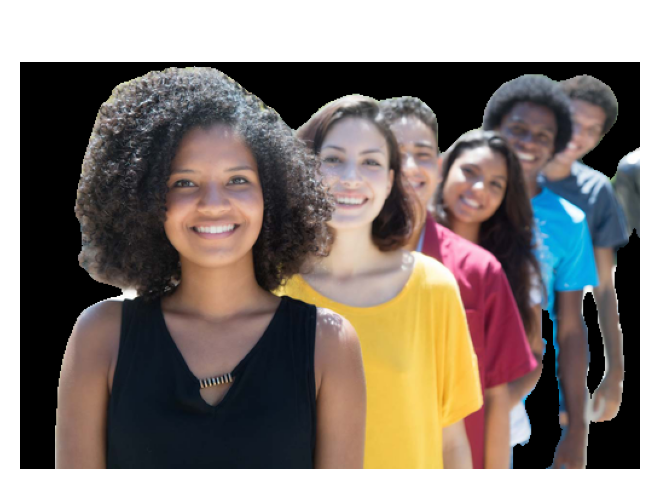

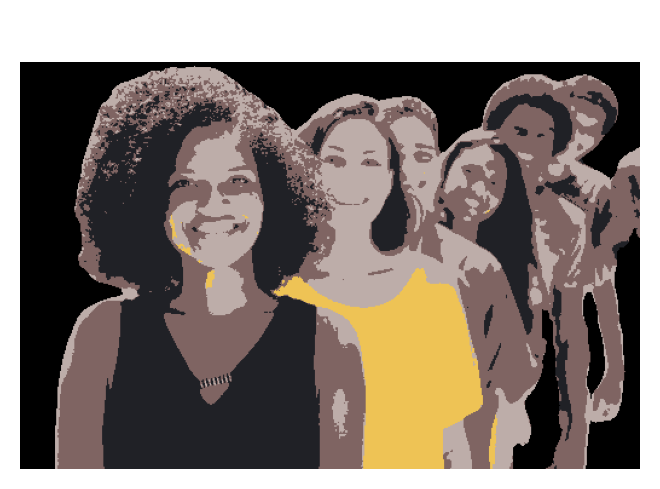

In [43]:
#@title Run Color Quantization / Color Quantizationı Çalıştır
# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause
# https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html 
print(__doc__)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
n_colors = 4 #@param {type: "slider", min: 4, max: 64} 
#@markdown Önerilen Değer 4 

# Load the Summer Palace photo

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])

def color_quantization(image_array,n_colors):
  image_array = np.array(image_array, dtype=np.float64) / 255

  print("Fitting model on a small sub-sample of the data")
  image_array_sample = shuffle(image_array, random_state=0)[:1000]
  kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

  # Get labels for all points
  print("Predicting color indices on the full image (k-means)")
  labels = kmeans.predict(image_array)
  return kmeans,labels

# ALL IMAGE
image = im.copy()
# Load Image and transform to a 2D numpy array.
print(image.shape)
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))
kmeans , labels = color_quantization(image_array,n_colors)

# Bıggest connected Component 
biggest_compoonent_kmeans,biggest_compoonent_labels = color_quantization(hist_array.copy(),n_colors)
Quantization_time = time.time()
# We will use this variable only make a histogram . We won't recreate image from this labels



def recreate_image(codebook, labels, w, h):
    
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            if(np.array_equal(mask[i][j], np.array((True,True,True)) ) ):
              image[i][j] = codebook[labels[label_idx]]
              label_idx += 1
            else:
              image[i][j] = np.array(background_color) / 255
    return image

plt.figure(1 ,figsize=(4,5) , dpi = 200)
plt.clf()
plt.axis('off')
plt.title('Original image')
plt.imshow(image)

plt.figure(2,figsize=(4,5) , dpi = 200)
plt.clf()
plt.axis('off')
plt.title('Color Quantized image')
recreated_image = recreate_image(biggest_compoonent_kmeans.cluster_centers_, biggest_compoonent_labels, w, h)
plt.imshow(recreated_image)
plt.show()

In [44]:
#@title Süre Ölçmek için bu kodu yorum satırından çıkabilirsin
'''
print(f"Semantic Segmantation time= { segmantation_time - start_time}")
print(f"Connected Component Labelibg time= { (connected_component_labeling_time -segmantation_time )}")
print(f"Connected Component Labelibg time= { ( Quantization_time - connected_component_labeling_time )}")
print(f"All time {Quantization_time - start_time}")
'''

'\nprint(f"Semantic Segmantation time= { segmantation_time - start_time}")\nprint(f"Connected Component Labelibg time= { (connected_component_labeling_time -segmantation_time )}")\nprint(f"Connected Component Labelibg time= { ( Quantization_time - connected_component_labeling_time )}")\nprint(f"All time {Quantization_time - start_time}")\n'

# Make Histogram / Histogramı Oluştur


4


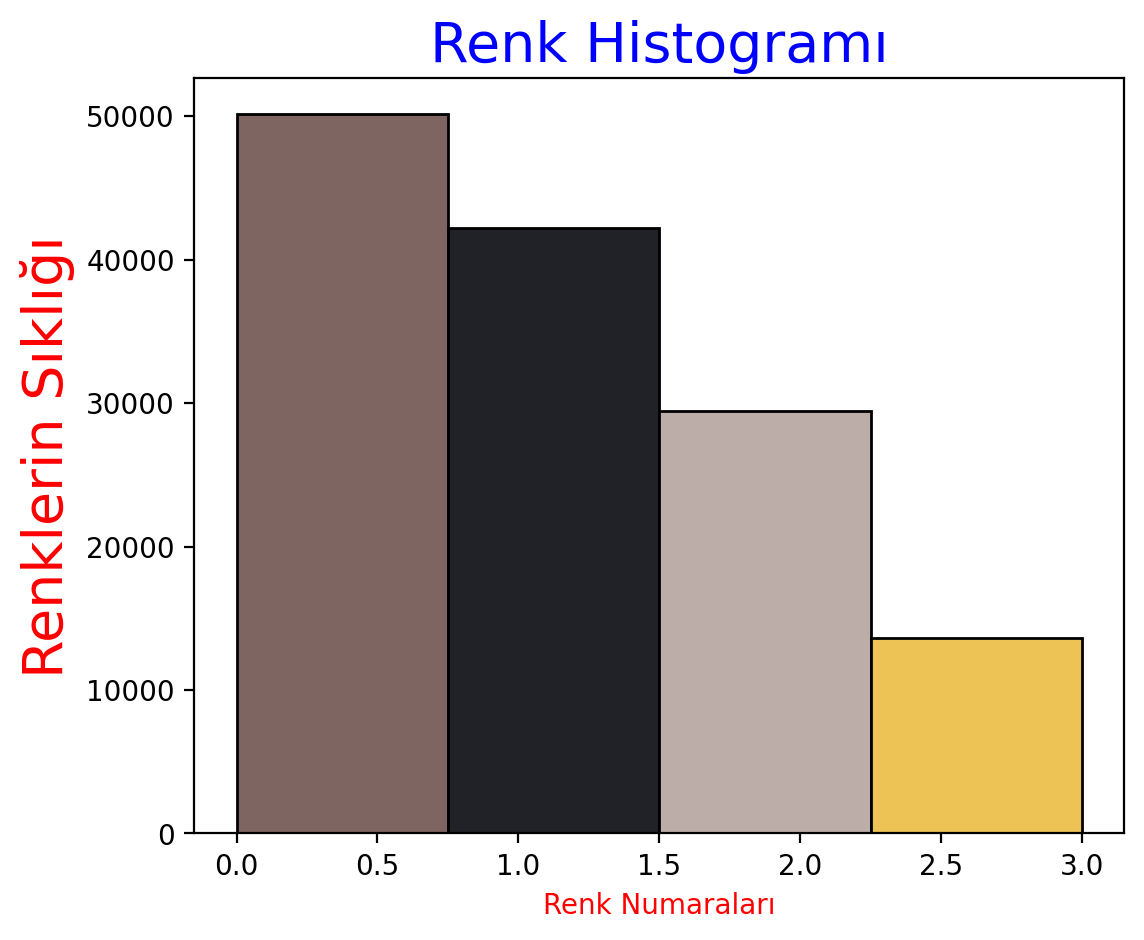

In [45]:
#@title Bar Histogram
zipped = zip(np.arange(0,n_colors) , np.bincount(biggest_compoonent_labels))
freqs = np. array (sorted(zipped, key = lambda x : x[1],reverse=True) ) 
color_numbers = freqs[:,0:1]
frequences = freqs[:,1:]

arrays = [] 
for i in range(len(color_numbers)):
  arrays.append(np.ones(frequences[i])*i)
biggest_compoonent_labels_new = np.reshape(np.concatenate(arrays) ,(-1) )

fig, ax = plt.subplots(figsize=(6,5),dpi=200)
N, bins, patches = ax.hist(biggest_compoonent_labels_new, edgecolor='black', linewidth=1,bins=n_colors,orientation  = "vertical")
print(len(patches))
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)
for idx,i in enumerate(color_numbers):
  color = biggest_compoonent_kmeans.cluster_centers_[i[0]]
  color = (color * 255).round().astype(np.uint8)
  hex_val = rgb2hex(*color)
  patches[idx].set_facecolor(hex_val)
plt.xlabel("Renk Numaraları",color="red")
plt.ylabel("Renklerin Sıklığı",color="red",size="20")
plt.title("Renk Histogramı",color = "blue",size = "20")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


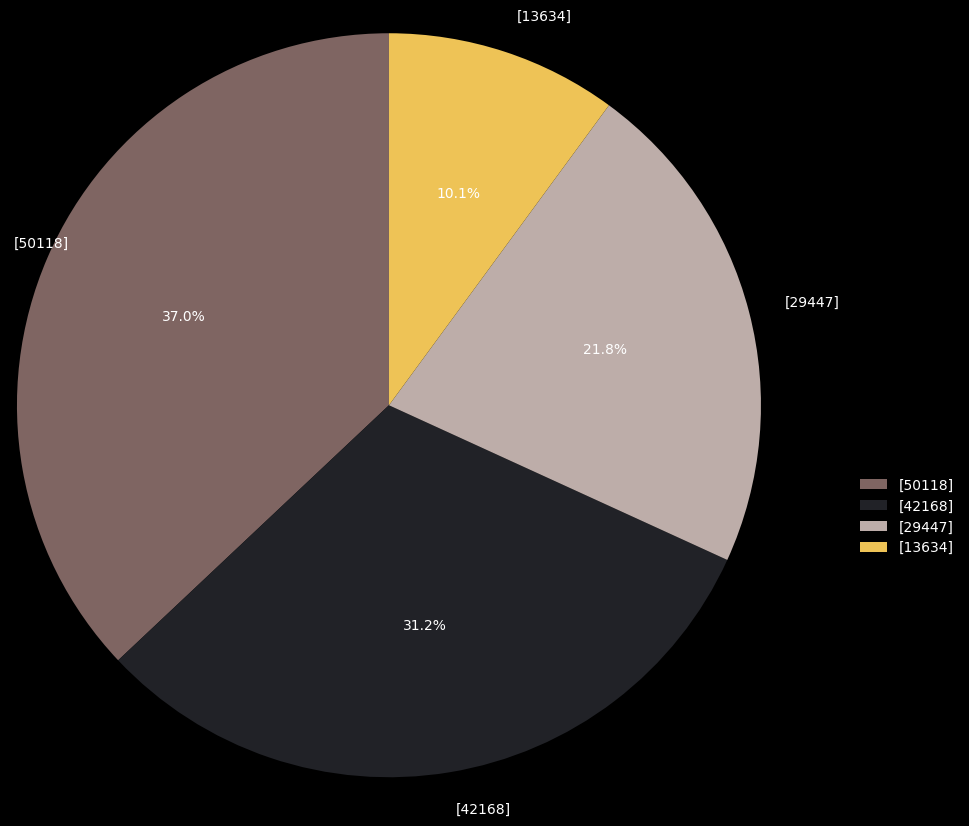

In [46]:
#@title Pie Histogram All Color



import matplotlib.pyplot as plt 
#fig.set_facecolor('white')



fig, ax = plt.subplots(figsize=(4,5),dpi=100)



fig.patch.set_color("black")
#fig.patch.set_facecolor('black') 
# Change color of text
plt.rcParams['text.color'] = 'white'

# defining labels 
activities =frequences
  
# portion covered by each label 
slices = frequences

colors = [] 
for i in color_numbers:
  color = biggest_compoonent_kmeans.cluster_centers_[i[0]]
  color = (color * 255).round().astype(np.uint8)
  hex_val = rgb2hex(*color)
  colors.append(hex_val)

# color for each label 

# plotting the pie chart 
plt.pie(slices, labels = activities,  colors=colors ,
        startangle=90, shadow = False, 
        radius = 3.0, autopct = '%1.1f%%',center = (5,5)) 
plt.legend(loc= (2,0) ,framealpha =0 , edgecolor = "yellow" , facecolor="white") 
# showing the plot 
plt.show() 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


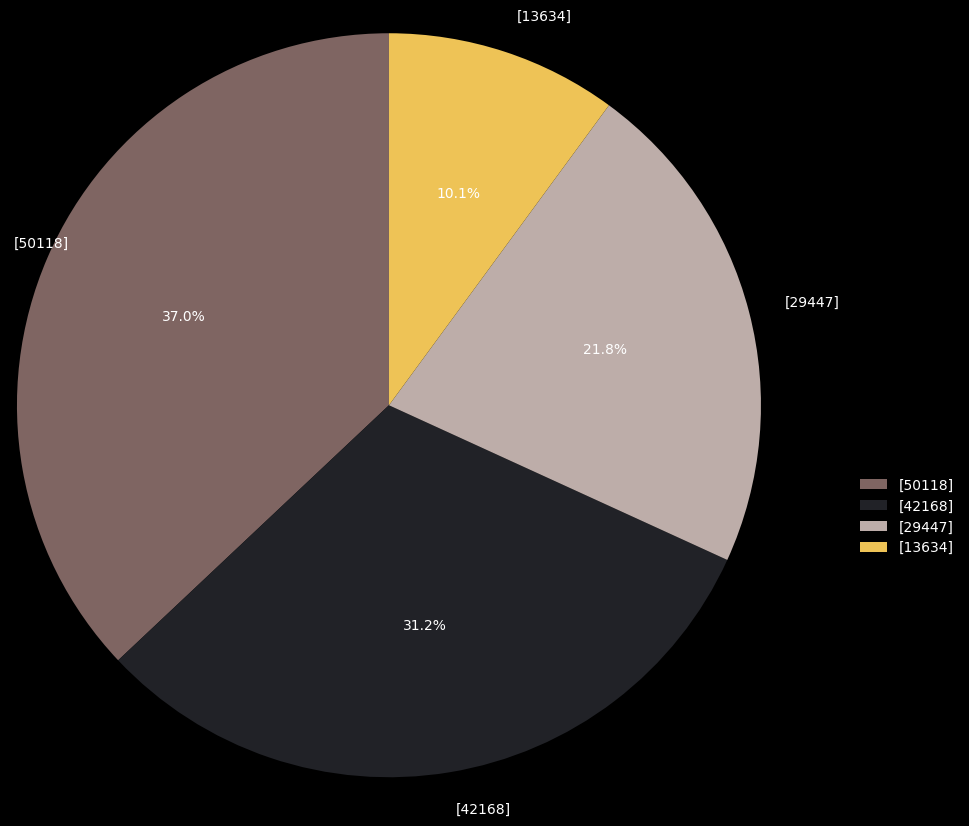

In [47]:
#@title Pie Histogram Most 4 Color

fig, ax = plt.subplots(figsize=(4,5),dpi=100)


fig.patch.set_color("black")

# Change color of text
plt.rcParams['text.color'] = 'white'

# defining labels 
activities =frequences[:4]
  
# portion covered by each label 
slices = frequences[:4]

colors = []
colors2 = color_numbers[:4] 
for i in colors2:
  color = biggest_compoonent_kmeans.cluster_centers_[i[0]]
  color = (color * 255).round().astype(np.uint8)
  hex_val = rgb2hex(*color)
  colors.append(hex_val)

# color for each label 

# plotting the pie chart 
plt.pie(slices, labels = activities,  colors=colors ,
        startangle=90, shadow = False, 
        radius = 3.0, autopct = '%1.1f%%',center = (5,5)) 
plt.legend(loc= (2,0) ,framealpha =0 , edgecolor = "yellow" , facecolor="white") 
# showing the plot 
plt.show() 

# Tüm fotoğrafın k-means değeri

Automatically created module for IPython interactive environment
(337, 513, 3)
Fitting model on a small sub-sample of the data
done in 0.068s.
Predicting color indices on the full image (k-means)
done in 0.022s.
4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


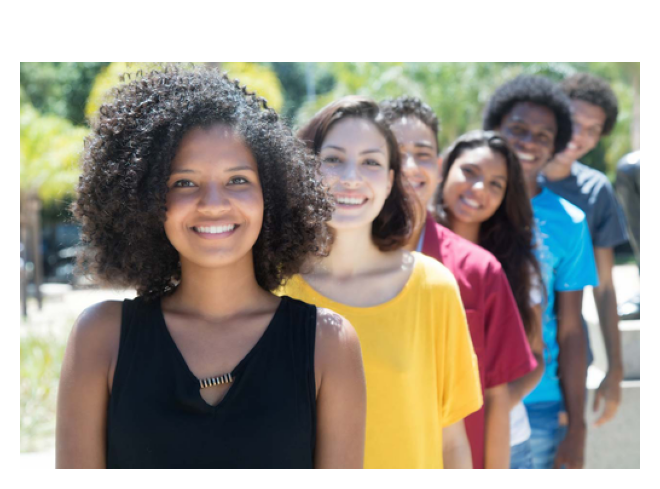

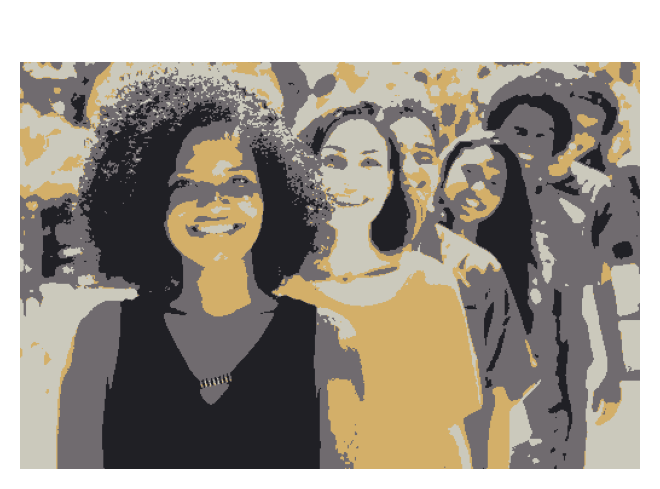

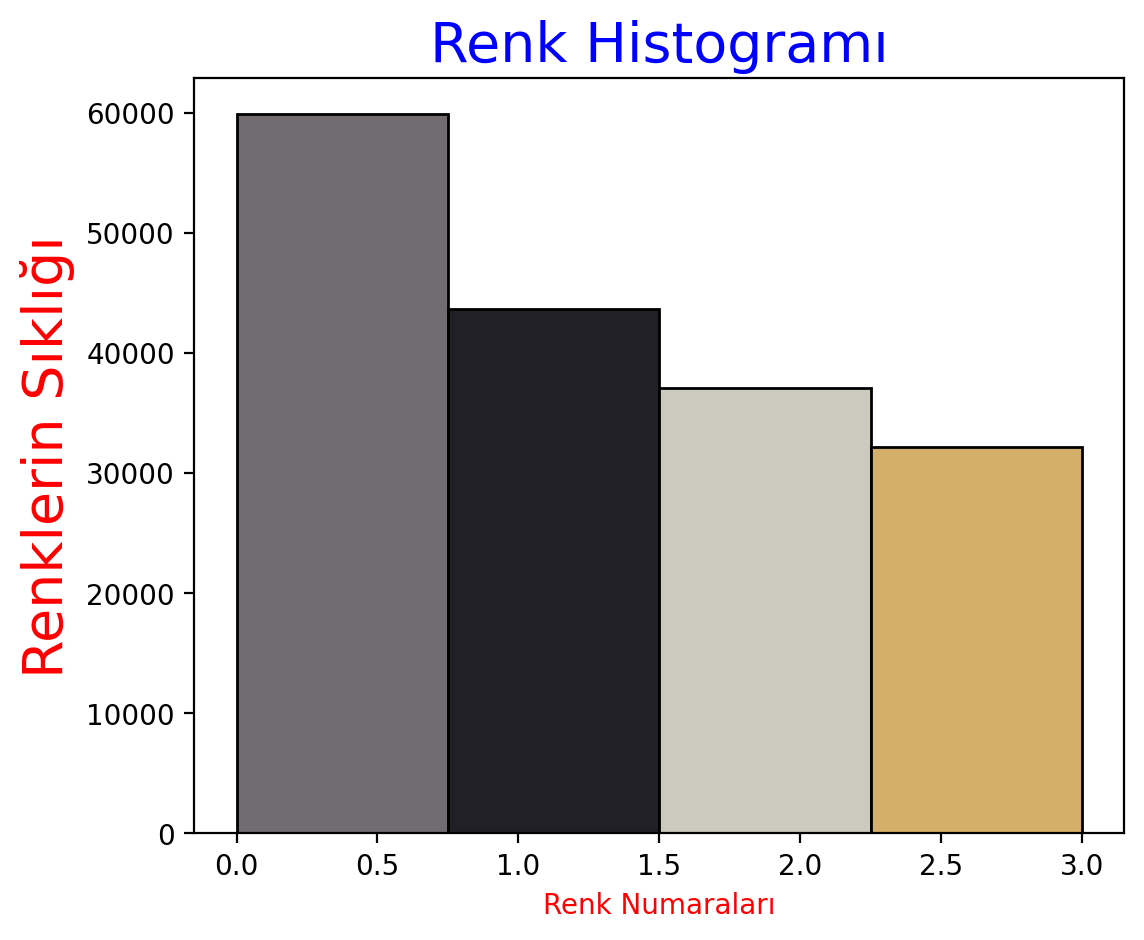

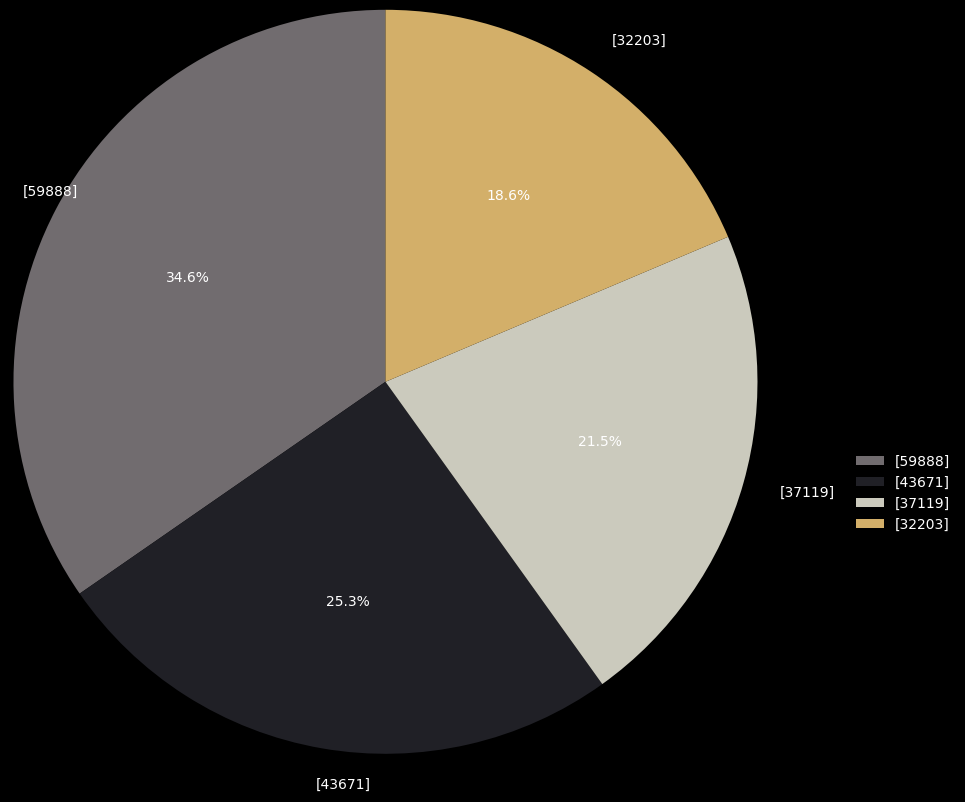

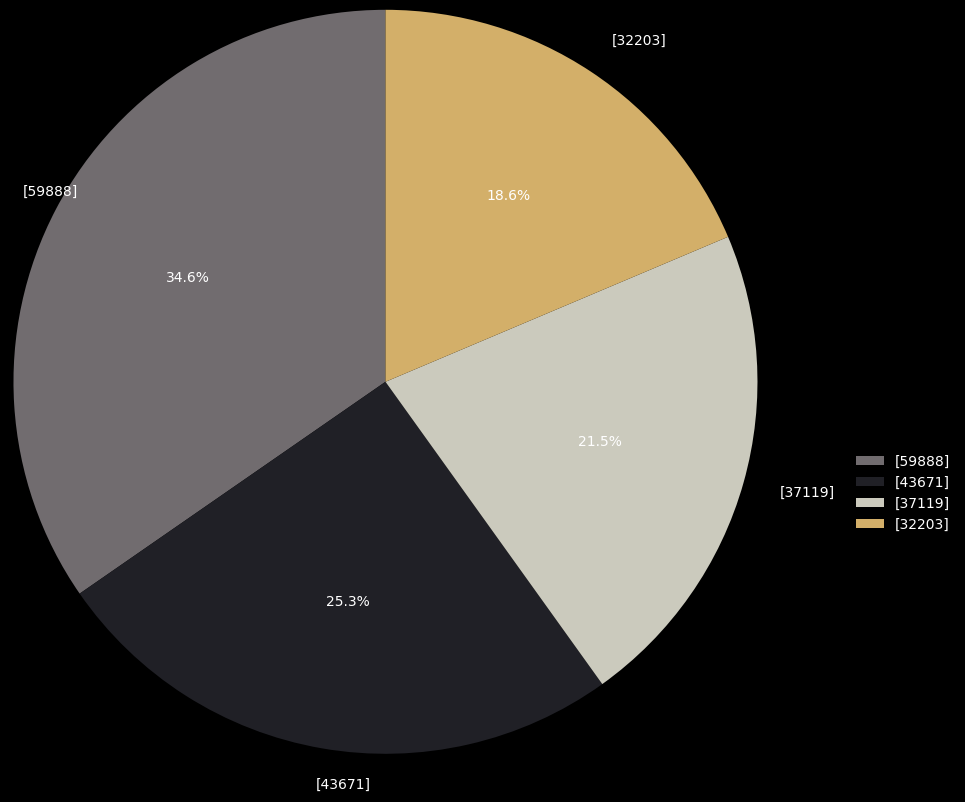

In [48]:
#@title Çalıştır
# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause

print(__doc__)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

# Load the Summer Palace photo

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])

def color_quantization(image_array,n_colors):
  image_array = np.array(image_array, dtype=np.float64) / 255

  print("Fitting model on a small sub-sample of the data")
  t0 = time()
  image_array_sample = shuffle(image_array, random_state=0)[:1000]
  kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
  print("done in %0.3fs." % (time() - t0))

  # Get labels for all points
  print("Predicting color indices on the full image (k-means)")
  t0 = time()
  labels = kmeans.predict(image_array)
  print("done in %0.3fs." % (time() - t0))
  return kmeans,labels

# ALL IMAGE
image = original_im.copy()
# Load Image and transform to a 2D numpy array.
print(image.shape)
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))
all_kmeans , all_labels = color_quantization(image_array,n_colors)

# We will use this variable only make a histogram . We won't recreate image from this labels



def recreate_image_all(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            #print(labels[label_idx])
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

plt.figure(1 ,figsize=(4,5) , dpi = 200)
plt.clf()
plt.axis('off')
plt.title('Original image')
plt.imshow(image)

plt.figure(2,figsize=(4,5) , dpi = 200)
plt.clf()
plt.axis('off')
plt.title('Color Quantized image')
recreated_image = recreate_image_all(all_kmeans.cluster_centers_, all_labels, w, h)
plt.imshow(recreated_image)
#plt.show()
#################################################################################################################################
zipped = zip(np.arange(0,n_colors) , np.bincount(all_labels))
freqs = np. array (sorted(zipped, key = lambda x : x[1],reverse=True) ) 
color_numbers = freqs[:,0:1]
frequences = freqs[:,1:]


arrays = [] 
for i in range(len(color_numbers)):
  arrays.append(np.ones(frequences[i])*i)
biggest_compoonent_labels_new = np.reshape(np.concatenate(arrays) ,(-1) )

fig, ax = plt.subplots(figsize=(6,5),dpi=200)
N, bins, patches = ax.hist(biggest_compoonent_labels_new, edgecolor='black', linewidth=1,bins=n_colors,orientation  = "vertical")
print(len(patches))
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)
for idx,i in enumerate(color_numbers):
  color = all_kmeans.cluster_centers_[i[0]]
  color = (color * 255).round().astype(np.uint8)
  hex_val = rgb2hex(*color)
  patches[idx].set_facecolor(hex_val)
plt.xlabel("Renk Numaraları",color="red")
plt.ylabel("Renklerin Sıklığı",color="red",size="20")
plt.title("Renk Histogramı",color = "blue",size = "20")
#plt.show()



###################################################################################################################################



import matplotlib.pyplot as plt 
#fig.set_facecolor('white')
fig, ax = plt.subplots(figsize=(4,5),dpi=100)

fig.patch.set_facecolor('black')
 
# Change color of text
plt.rcParams['text.color'] = 'white'

# defining labels 
activities =frequences
  
# portion covered by each label 
slices = frequences

colors = [] 
for i in color_numbers:
  color = all_kmeans.cluster_centers_[i[0]]
  color = (color * 255).round().astype(np.uint8)
  hex_val = rgb2hex(*color)
  colors.append(hex_val)

# color for each label 

# plotting the pie chart 
plt.plot(1,1)
plt.pie(slices, labels = activities,  colors=colors ,
        startangle=90, shadow = False, 
        radius = 3.0, autopct = '%1.1f%%',center = (5,5)) 
plt.legend(loc= (2,0) ,framealpha =0 , edgecolor = "yellow" , facecolor="white") 
# showing the plot 
#plt.show() 

##################################################################################################3
fig, ax = plt.subplots(figsize=(4,5),dpi=100)

fig.patch.set_facecolor('black')
 
# Change color of text
plt.rcParams['text.color'] = 'white'

# defining labels 
activities =frequences[:4]
  
# portion covered by each label 
slices = frequences[:4]

colors = []
colors2 = color_numbers[:4] 
for i in colors2:
  color = all_kmeans.cluster_centers_[i[0]]
  color = (color * 255).round().astype(np.uint8)
  hex_val = rgb2hex(*color)
  colors.append(hex_val)

# color for each label 

# plotting the pie chart 
plt.plot(1,2)
plt.pie(slices, labels = activities,  colors=colors ,
        startangle=90, shadow = False, 
        radius = 3.0, autopct = '%1.1f%%',center = (5,5)) 
plt.legend(loc= (2,0) ,framealpha =0 , edgecolor = "yellow" , facecolor="white") 
# showing the plot 
plt.show() 